### RFE MANUAL

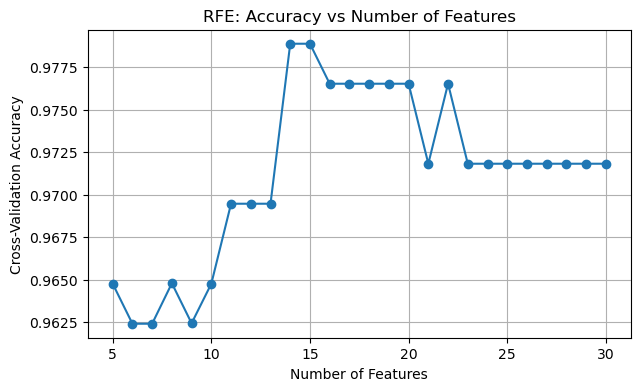

✅ Accuracy: 0.9790

📋 Classification Report:

              precision    recall  f1-score   support

   malignant       0.96      0.98      0.97        53
      benign       0.99      0.98      0.98        90

    accuracy                           0.98       143
   macro avg       0.98      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143



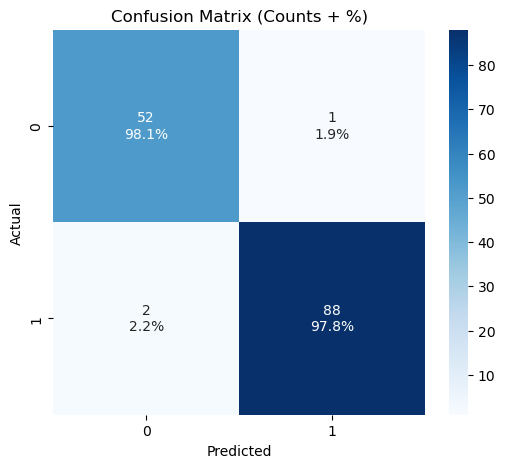

📦 Model, scaler, and selected features saved.

🔍 Predicting on a new sample:
Prediction: Malignant
Probability: Malignant=1.0000, Benign=0.0000


In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load built-in dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression
log_reg = LogisticRegression(max_iter=5000)

# RFE with cross-validation to select best number of features
best_score = 0
best_features = None
scores = []
feature_counts = list(range(5, X.shape[1] + 1))

for n in feature_counts:
    rfe = RFE(log_reg, n_features_to_select=n)
    rfe.fit(X_train_scaled, y_train)
    score = np.mean(cross_val_score(log_reg, X_train_scaled[:, rfe.support_], y_train, cv=5))
    scores.append(score)
    if score > best_score:
        best_score = score
        best_features = X.columns[rfe.support_]

# Plot Accuracy vs Number of Features
plt.figure(figsize=(7, 4))
plt.plot(feature_counts, scores, marker='o')
plt.title("RFE: Accuracy vs Number of Features")
plt.xlabel("Number of Features")
plt.ylabel("Cross-Validation Accuracy")
plt.grid(True)
plt.show()

# Final model with best features
X_train_sel = X_train[best_features]
X_test_sel = X_test[best_features]

scaler_final = StandardScaler()
X_train_sel_scaled = scaler_final.fit_transform(X_train_sel)
X_test_sel_scaled = scaler_final.transform(X_test_sel)

log_reg.fit(X_train_sel_scaled, y_train)
y_pred = log_reg.predict(X_test_sel_scaled)

# Evaluation
acc = accuracy_score(y_test, y_pred)
print(f"✅ Accuracy: {acc:.4f}\n")

print("📋 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=data.target_names))

# Confusion matrix with % values
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
labels = np.array([
    [f"{conf_mat[i,j]}\n{conf_mat_norm[i,j]*100:.1f}%" for j in range(conf_mat.shape[1])]
    for i in range(conf_mat.shape[0])
])

plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=labels, fmt='', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Counts + %)")
plt.show()

# Save model and components
joblib.dump(log_reg, "log_reg_model.pkl")
joblib.dump(scaler_final, "scaler.pkl")
joblib.dump(best_features, "selected_features.pkl")
print("📦 Model, scaler, and selected features saved.")

# Simulate new prediction
print("\n🔍 Predicting on a new sample:")
new_sample = pd.DataFrame([X.iloc[0][best_features]])
scaled = scaler_final.transform(new_sample)
pred = log_reg.predict(scaled)
prob = log_reg.predict_proba(scaled)

print(f"Prediction: {'Benign' if pred[0] == 1 else 'Malignant'}")
print(f"Probability: Malignant={prob[0][0]:.4f}, Benign={prob[0][1]:.4f}")


In [3]:
# Combine X and y
full_df = X.copy()
full_df['target'] = y

# Save to CSV
full_df.to_csv("breast_cancer_full.csv", index=False)
print("✅ Saved full dataset as 'breast_cancer_full.csv'")


✅ Saved full dataset as 'breast_cancer_full.csv'


### RFECV

✅ Optimal number of features: 14
🧪 Selected Features: ['mean radius', 'mean area', 'mean concave points', 'radius error', 'area error', 'compactness error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst concavity', 'worst concave points', 'worst symmetry']


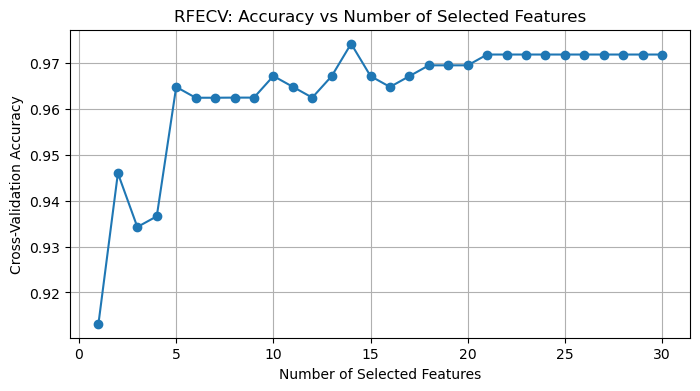


🎯 Final Accuracy: 0.9790

📋 Classification Report:
              precision    recall  f1-score   support

   malignant       0.96      0.98      0.97        53
      benign       0.99      0.98      0.98        90

    accuracy                           0.98       143
   macro avg       0.98      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143



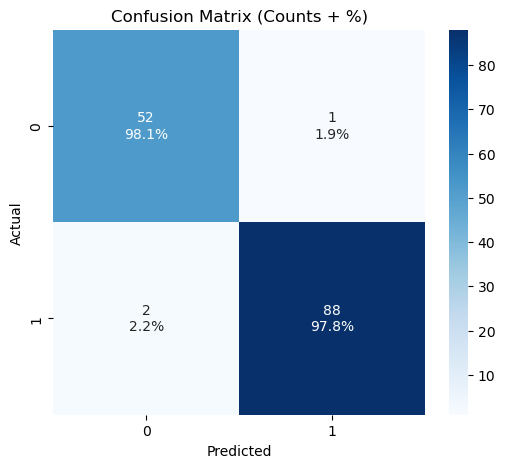

📦 Model, scaler, and selected features saved.

🔍 Predicting on a new sample:
Prediction: Malignant
Probability: Malignant=1.0000, Benign=0.0000


In [6]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load built-in dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression model
log_reg = LogisticRegression(max_iter=5000)

# RFECV: Recursive Feature Elimination with Cross-Validation
cv = StratifiedKFold(n_splits=5)
rfecv = RFECV(estimator=log_reg, step=1, cv=cv, scoring='accuracy')
rfecv.fit(X_train_scaled, y_train)

# Summary
print(f"✅ Optimal number of features: {rfecv.n_features_}")
selected_features = X.columns[rfecv.support_]
print(f"🧪 Selected Features: {list(selected_features)}")

# Plot RFECV scores
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"], marker='o')
plt.title("RFECV: Accuracy vs Number of Selected Features")
plt.xlabel("Number of Selected Features")
plt.ylabel("Cross-Validation Accuracy")
plt.grid(True)
plt.show()

# Final model training with selected features
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

scaler_final = StandardScaler()
X_train_sel_scaled = scaler_final.fit_transform(X_train_sel)
X_test_sel_scaled = scaler_final.transform(X_test_sel)

log_reg.fit(X_train_sel_scaled, y_train)
y_pred = log_reg.predict(X_test_sel_scaled)

# Evaluation
acc = accuracy_score(y_test, y_pred)
print(f"\n🎯 Final Accuracy: {acc:.4f}")
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=data.target_names))

# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
labels = np.array([
    [f"{conf_mat[i,j]}\n{conf_mat_norm[i,j]*100:.1f}%" for j in range(conf_mat.shape[1])]
    for i in range(conf_mat.shape[0])
])

plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=labels, fmt='', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Counts + %)")
plt.show()

# Save model and components
joblib.dump(log_reg, "log_reg_model.pkl")
joblib.dump(scaler_final, "scaler.pkl")
joblib.dump(selected_features, "selected_features.pkl")
print("📦 Model, scaler, and selected features saved.")

# Simulate new prediction
print("\n🔍 Predicting on a new sample:")
new_sample = pd.DataFrame([X.iloc[0][selected_features]])
scaled = scaler_final.transform(new_sample)
pred = log_reg.predict(scaled)
prob = log_reg.predict_proba(scaled)

print(f"Prediction: {'Benign' if pred[0] == 1 else 'Malignant'}")
print(f"Probability: Malignant={prob[0][0]:.4f}, Benign={prob[0][1]:.4f}")


### RANDOMFOREST+RFECV

🌲 RFECV (Random Forest) selected 14 features.
🧪 Selected Features:
['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean concavity', 'mean concave points', 'area error', 'worst radius', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points']


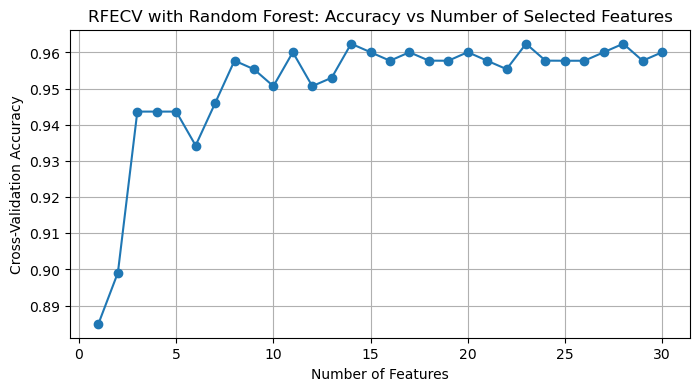


🎯 Random Forest Final Accuracy: 0.9580

📋 Classification Report:
              precision    recall  f1-score   support

   malignant       0.96      0.92      0.94        53
      benign       0.96      0.98      0.97        90

    accuracy                           0.96       143
   macro avg       0.96      0.95      0.95       143
weighted avg       0.96      0.96      0.96       143



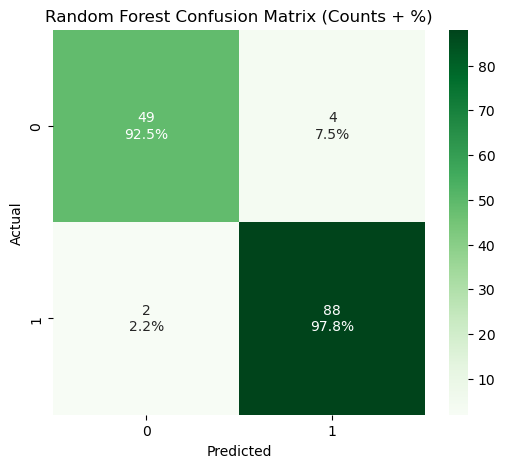

In [11]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42)

# Optional: scale for uniformity, although RF doesn't need it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# RFECV with Random Forest
cv = StratifiedKFold(n_splits=5)
rfecv = RFECV(estimator=rf_model, step=1, cv=cv, scoring='accuracy')
rfecv.fit(X_train_scaled, y_train)

# Summary
print(f"🌲 RFECV (Random Forest) selected {rfecv.n_features_} features.")
selected_features_rf = X.columns[rfecv.support_]
print(f"🧪 Selected Features:\n{list(selected_features_rf)}")

# Plot CV scores
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"], marker='o')
plt.title("RFECV with Random Forest: Accuracy vs Number of Selected Features")
plt.xlabel("Number of Features")
plt.ylabel("Cross-Validation Accuracy")
plt.grid(True)
plt.show()

# Final model evaluation
X_train_sel = X_train[selected_features_rf]
X_test_sel = X_test[selected_features_rf]

rf_model.fit(X_train_sel, y_train)
y_pred = rf_model.predict(X_test_sel)

acc = accuracy_score(y_test, y_pred)
print(f"\n🎯 Random Forest Final Accuracy: {acc:.4f}")
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=data.target_names))

# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
labels = np.array([
    [f"{conf_mat[i,j]}\n{conf_mat_norm[i,j]*100:.1f}%" for j in range(conf_mat.shape[1])]
    for i in range(conf_mat.shape[0])
])

plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=labels, fmt='', cmap='Greens')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix (Counts + %)")
plt.show()


### RANDOM FOREST


✅ Random Forest Accuracy (All Features): 0.9580

📋 Classification Report:
              precision    recall  f1-score   support

   malignant       0.96      0.92      0.94        53
      benign       0.96      0.98      0.97        90

    accuracy                           0.96       143
   macro avg       0.96      0.95      0.95       143
weighted avg       0.96      0.96      0.96       143



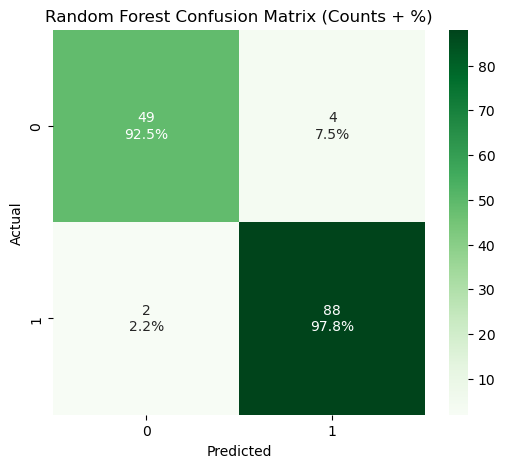

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42)

# Train Random Forest (no scaling, no RFE)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Evaluate performance
acc = accuracy_score(y_test, y_pred)
print(f"✅ Random Forest Accuracy (All Features): {acc:.4f}")
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=data.target_names))

# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
labels = np.array([
    [f"{conf_mat[i,j]}\n{conf_mat_norm[i,j]*100:.1f}%" for j in range(conf_mat.shape[1])]
    for i in range(conf_mat.shape[0])
])

plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=labels, fmt='', cmap='Greens')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix (Counts + %)")
plt.show()


### LOGISTIC REGRESSION ALL FEATURES

✅ Logistic Regression Accuracy (All Features): 0.9860

📋 Classification Report:
              precision    recall  f1-score   support

   malignant       0.98      0.98      0.98        53
      benign       0.99      0.99      0.99        90

    accuracy                           0.99       143
   macro avg       0.99      0.99      0.99       143
weighted avg       0.99      0.99      0.99       143



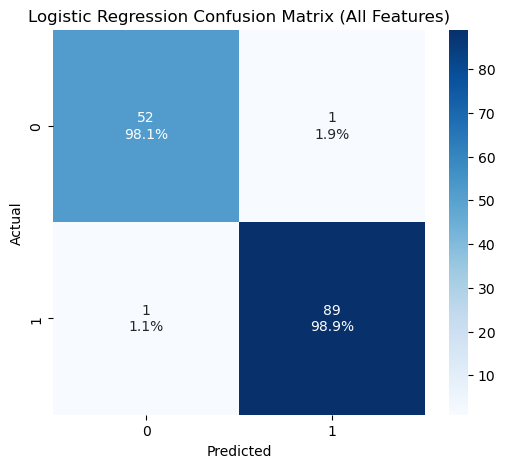

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Load data
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression (all features)
log_reg = LogisticRegression(max_iter=5000)
log_reg.fit(X_train_scaled, y_train)
y_pred = log_reg.predict(X_test_scaled)

# Evaluate
acc = accuracy_score(y_test, y_pred)
print(f"✅ Logistic Regression Accuracy (All Features): {acc:.4f}")
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=data.target_names))

# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
labels = np.array([
    [f"{conf_mat[i,j]}\n{conf_mat_norm[i,j]*100:.1f}%" for j in range(conf_mat.shape[1])]
    for i in range(conf_mat.shape[0])
])

plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=labels, fmt='', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression Confusion Matrix (All Features)")
plt.show()


### LOGISTIC REGRESSION L1 REGULATION

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

# L1 Logistic Regression
log_reg_l1 = LogisticRegression(penalty='l1', solver='liblinear', max_iter=5000, C=1.0)
log_reg_l1.fit(X_train_scaled, y_train)

# Select non-zero features
selector = SelectFromModel(log_reg_l1, prefit=True)
X_train_l1 = selector.transform(X_train_scaled)
X_test_l1 = selector.transform(X_test_scaled)

selected_features = X.columns[selector.get_support()]
print(f"🧠 Selected {len(selected_features)} features using L1 regularization:")
print(list(selected_features))

# Fit model again on selected features
log_reg_l1.fit(X_train_l1, y_train)
y_pred_l1 = log_reg_l1.predict(X_test_l1)

# Evaluation
acc_l1 = accuracy_score(y_test, y_pred_l1)
print(f"\n✅ Logistic Regression (L1 Selected) Accuracy: {acc_l1:.4f}")
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred_l1, target_names=data.target_names))


🧠 Selected 16 features using L1 regularization:
['mean texture', 'mean concave points', 'radius error', 'texture error', 'area error', 'smoothness error', 'compactness error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst area', 'worst smoothness', 'worst concavity', 'worst concave points', 'worst symmetry']

✅ Logistic Regression (L1 Selected) Accuracy: 0.9930

📋 Classification Report:
              precision    recall  f1-score   support

   malignant       1.00      0.98      0.99        53
      benign       0.99      1.00      0.99        90

    accuracy                           0.99       143
   macro avg       0.99      0.99      0.99       143
weighted avg       0.99      0.99      0.99       143



### SEQUENCIAL FEATURE SELECTION

In [26]:
!pip install mlxtend


   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.4 MB ? eta -:--:--
   ------------------------------- -------- 1.0/1.4 MB 6.3 MB/s eta 0:00:01
   ------------------------------- -------- 1.0/1.4 MB 6.3 MB/s eta 0:00:01
   -------------------------------------- - 1.3/1.4 MB 2.2 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 1.6 MB/s eta 0:00:00


In [28]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Recreate model
log_reg = LogisticRegression(max_iter=5000, solver='liblinear')

# SFS with forward selection (you can try backward=True as well)
sfs = SFS(log_reg,
          k_features='best',  # or set an int like 14
          forward=True,
          floating=False,
          scoring='accuracy',
          cv=5,
          n_jobs=-1)

sfs = sfs.fit(X_train_scaled, y_train)

# Get selected features
sfs_selected_idx = list(sfs.k_feature_idx_)
sfs_selected_features = X.columns[sfs_selected_idx]
print(f"🧠 SFS selected {len(sfs_selected_features)} features:")
print(list(sfs_selected_features))

# Train final model
X_train_sfs = X_train_scaled[:, sfs_selected_idx]
X_test_sfs = X_test_scaled[:, sfs_selected_idx]

log_reg.fit(X_train_sfs, y_train)
y_pred_sfs = log_reg.predict(X_test_sfs)

# Evaluation
acc_sfs = accuracy_score(y_test, y_pred_sfs)
print(f"\n✅ Logistic Regression (SFS) Accuracy: {acc_sfs:.4f}")
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred_sfs, target_names=data.target_names))


🧠 SFS selected 14 features:
['mean compactness', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'texture error', 'smoothness error', 'compactness error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst symmetry']

✅ Logistic Regression (SFS) Accuracy: 0.9790

📋 Classification Report:
              precision    recall  f1-score   support

   malignant       0.96      0.98      0.97        53
      benign       0.99      0.98      0.98        90

    accuracy                           0.98       143
   macro avg       0.98      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143



### GRADIENT BOOSTING CLASSIFIER

✅ Gradient Boosting Accuracy: 0.9580

📋 Classification Report:
              precision    recall  f1-score   support

   malignant       0.98      0.91      0.94        53
      benign       0.95      0.99      0.97        90

    accuracy                           0.96       143
   macro avg       0.96      0.95      0.95       143
weighted avg       0.96      0.96      0.96       143



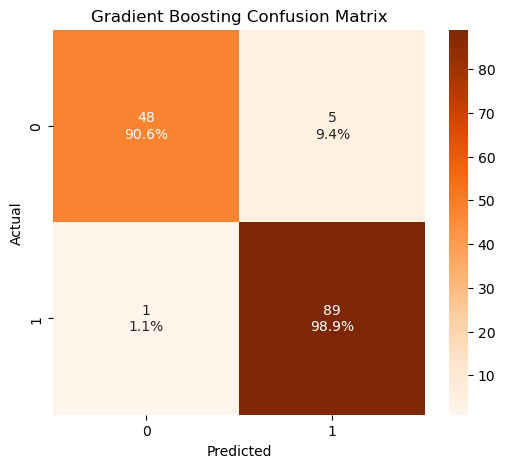

In [31]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# No need to scale for tree-based models
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

# Evaluate
acc_gb = accuracy_score(y_test, y_pred_gb)
print(f"✅ Gradient Boosting Accuracy: {acc_gb:.4f}")
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred_gb, target_names=data.target_names))

# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

conf_mat = confusion_matrix(y_test, y_pred_gb)
conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
labels = np.array([
    [f"{conf_mat[i,j]}\n{conf_mat_norm[i,j]*100:.1f}%" for j in range(conf_mat.shape[1])]
    for i in range(conf_mat.shape[0])
])

plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=labels, fmt='', cmap='Oranges')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Gradient Boosting Confusion Matrix")
plt.show()


In [33]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Param grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'max_features': ['sqrt', 'log2']
}

gb = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=gb,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

# Best model
best_gb = grid_search.best_estimator_
print(f"\n✅ Best Params: {grid_search.best_params_}")

# Predict and evaluate
y_pred_best = best_gb.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

acc_best = accuracy_score(y_test, y_pred_best)
print(f"\n🎯 Tuned Gradient Boosting Accuracy: {acc_best:.4f}")
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred_best, target_names=data.target_names))


Fitting 5 folds for each of 108 candidates, totalling 540 fits

✅ Best Params: {'learning_rate': 0.1, 'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 200, 'subsample': 1.0}

🎯 Tuned Gradient Boosting Accuracy: 0.9650

📋 Classification Report:
              precision    recall  f1-score   support

   malignant       0.98      0.92      0.95        53
      benign       0.96      0.99      0.97        90

    accuracy                           0.97       143
   macro avg       0.97      0.96      0.96       143
weighted avg       0.97      0.97      0.96       143



### XGBOOST

C:\Users\gnane\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:12:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ XGBoost Accuracy: 0.9580

📋 Classification Report:
              precision    recall  f1-score   support

   malignant       0.96      0.92      0.94        53
      benign       0.96      0.98      0.97        90

    accuracy                           0.96       143
   macro avg       0.96      0.95      0.95       143
weighted avg       0.96      0.96      0.96       143



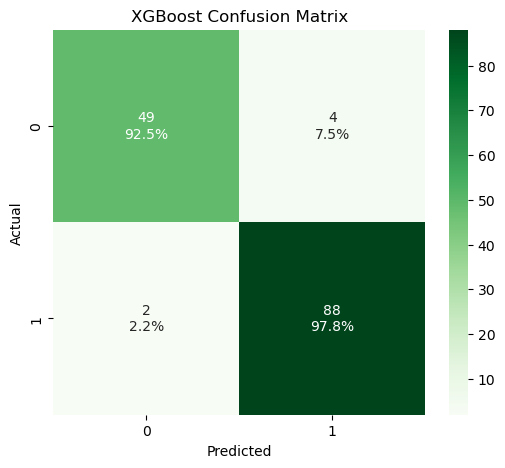

In [39]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# XGBoost Classifier
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=3,
    learning_rate=0.1,
    subsample=1.0,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Train on unscaled data (XGBoost doesn't need scaling)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
acc_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"✅ XGBoost Accuracy: {acc_xgb:.4f}")
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=data.target_names))

# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

conf_mat = confusion_matrix(y_test, y_pred_xgb)
conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
labels = np.array([
    [f"{conf_mat[i,j]}\n{conf_mat_norm[i,j]*100:.1f}%" for j in range(conf_mat.shape[1])]
    for i in range(conf_mat.shape[0])
])

plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=labels, fmt='', cmap='Greens')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost Confusion Matrix")
plt.show()


### XGBOOST BASED FEATURE SELECTION

C:\Users\gnane\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:17:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\gnane\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:17:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\gnane\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:17:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\gnane\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:17:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtr


🔍 Top feature set sizes by accuracy:
    top_n_features  accuracy
25              30  0.965035
15              20  0.965035
24              29  0.965035
23              28  0.965035
21              26  0.965035


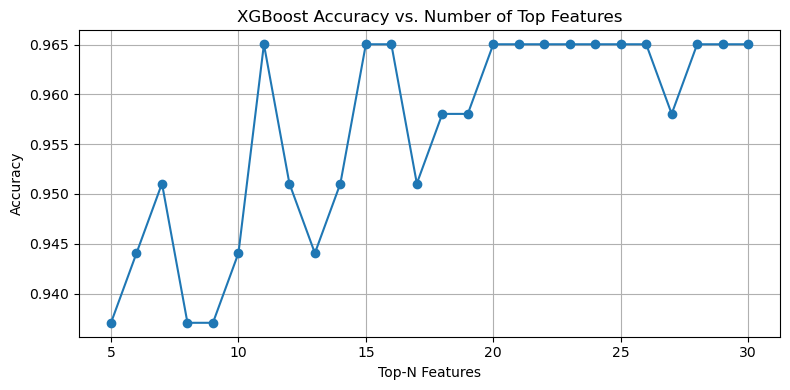

In [44]:
from sklearn.metrics import accuracy_score
import pandas as pd

# Get importance (actual feature names)
importances = xgb_model.get_booster().get_score(importance_type='gain')
importances = pd.Series(importances).sort_values(ascending=False)

results = []

# Try different top_n values
for top_n in range(5, 31):
    selected_features = list(importances.head(top_n).index)
    
    # Train/test subset
    X_train_sel = X_train[selected_features]
    X_test_sel = X_test[selected_features]
    
    model = XGBClassifier(
        n_estimators=200,
        max_depth=3,
        learning_rate=0.1,
        subsample=1.0,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
    
    model.fit(X_train_sel, y_train)
    y_pred = model.predict(X_test_sel)
    
    acc = accuracy_score(y_test, y_pred)
    results.append((top_n, acc))

# Convert to DataFrame for analysis
results_df = pd.DataFrame(results, columns=['top_n_features', 'accuracy'])

# Show top 5
print("\n🔍 Top feature set sizes by accuracy:")
print(results_df.sort_values(by='accuracy', ascending=False).head())

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.plot(results_df['top_n_features'], results_df['accuracy'], marker='o')
plt.title("XGBoost Accuracy vs. Number of Top Features")
plt.xlabel("Top-N Features")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()


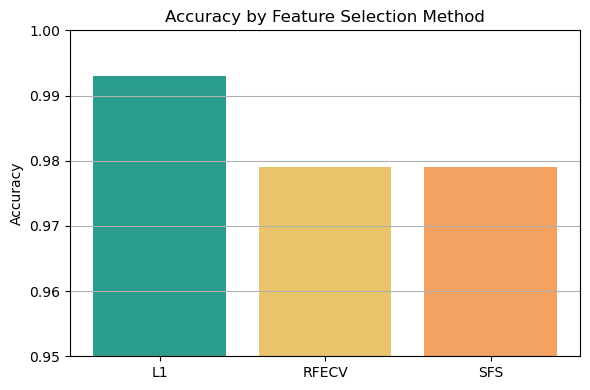

In [58]:
import matplotlib.pyplot as plt

methods = ['L1', 'RFECV', 'SFS']
accuracies = [0.993, 0.979, 0.979]

plt.figure(figsize=(6,4))
plt.bar(methods, accuracies, color=['#2a9d8f', '#e9c46a', '#f4a261'])
plt.title("Accuracy by Feature Selection Method")
plt.ylabel("Accuracy")
plt.ylim(0.95, 1.0)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("accuracy_comparison.png")


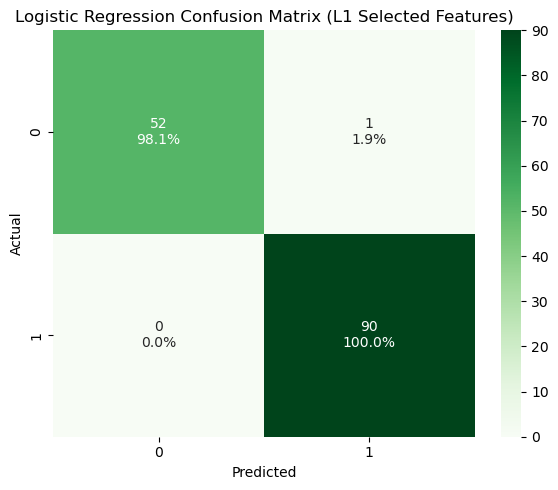

In [68]:
# Confusion matrix for L1 model
conf_mat_l1 = confusion_matrix(y_test, y_pred_l1)
conf_mat_l1_norm = conf_mat_l1.astype('float') / conf_mat_l1.sum(axis=1)[:, np.newaxis]

# Create count + percent labels
labels_l1 = np.array([
    [f"{conf_mat_l1[i,j]}\n{conf_mat_l1_norm[i,j]*100:.1f}%" for j in range(conf_mat_l1.shape[1])]
    for i in range(conf_mat_l1.shape[0])
])

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat_l1, annot=labels_l1, fmt='', cmap='Greens')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression Confusion Matrix (L1 Selected Features)")
plt.tight_layout()

# Save figure
plt.savefig("confusion_matrix_l1_pct.png", dpi=300, bbox_inches='tight')
plt.show()
